In [1]:
# Get Dependencies
# !wget -cO - https://github.com/Ouwen/MimickNet/blob/master/examples/models/python_mimicknet.h5?raw=true > python_mimicknet.h5
# !git clone https://github.com/ouwen/datasets.git # Not needed once duke_ultrasound is integrated into the official repo
# !pip3 install tensorflow-datasets
# !pip3 install polarTransform
%cd datasets
# %cd ..
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


/home/jupyter/BME590-Perceptual-Loss-Style-Transfer/datasets


In [2]:

# from skimage.transform import match_histograms


# set data_dir locally for faster performance
# note that download and extraction can take ~3 hours
ds = tfds.load('duke_ultrasound', data_dir='gs://duke-tfds')

In [3]:
def scan_convert(image, irad, frad, iang, fang):
  """Scan converts beam lines"""
  image, _ = polarTransform.convertToCartesianImage(
      np.transpose(image),
      initialRadius=irad,
      finalRadius=frad,
      initialAngle=iang,
      finalAngle=fang,
      hasColor=False,
      order=1)
  return np.transpose(image[:, int(irad):])
  
def process(ele):
  """Cuts to -80 dB and normalizes images from 0 to 1"""
  ele['das'] = tf.reshape(ele['das']['dB'], [ele['height'], ele['width']])
  ele['das'] = tf.clip_by_value(ele['das'], -80, 0)
  ele['das'] = (ele['das'] - tf.reduce_min(ele['das']))/(tf.reduce_max(ele['das']) - tf.reduce_min(ele['das']))

  ele['dtce'] = tf.reshape(ele['dtce'], [ele['height'], ele['width']])
  ele['dtce'] = (ele['dtce'] - tf.reduce_min(ele['dtce']))/(tf.reduce_max(ele['dtce']) - tf.reduce_min(ele['dtce']))
  image = tf.image.resize(ele['das'][..., None], [512, 512])
  image = tf.image.grayscale_to_rgb(image)
  print(image.shape)
  return image, image

# ds_ite = iter(ds['MARK'])
# ele = next(ds_ite)
# x, y = process(ele)
train_ds = ds['MARK'].map(process) # Splits: MARK, TRAIN, VALIDATION, TEST, A, B
train_ds = train_ds.batch(4).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def just_das(ele):
    converted = scan_convert(ele['das'].numpy(),
                            ele['initial_radius'].numpy(),
                            ele['final_radius'].numpy(),
                            ele['initial_angle'].numpy(),
                            ele['final_angle'].numpy())
    return converted, converted

(512, 512, 3)


In [4]:
# ele = next(train_iter)
# converted = scan_convert(ele['das'].numpy(),
#                             ele['initial_radius'].numpy(),
#                             ele['final_radius'].numpy(),
#                             ele['initial_angle'].numpy(),
#                             ele['final_angle'].numpy())


In [5]:
# model = transformer_model()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#               loss=losses.full_loss(face))
# model.load_weights('sketch_sw3_cw1_tv1e-4_coco_instancenorm.h5')

(4, 512, 512, 3)
254.61752 24.513199


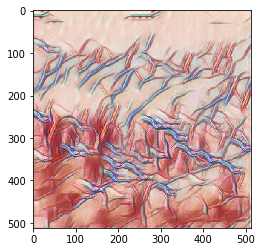

In [31]:
# train_iter = iter(train_ds)

x,y = next(train_iter)
print(x.shape)
results = model.predict(x)
plt.imshow(results[0].astype(np.uint8))
print(np.max(results[0]), np.min(results[0]))

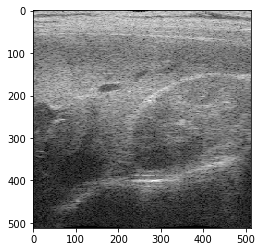

In [32]:
plt.imshow(x[0].numpy())

In [29]:
%cd ..

# from trainer.utils import losses
from trainer.models.transformer import transformer_model

/home/jupyter


(1, 512, 438, 3)


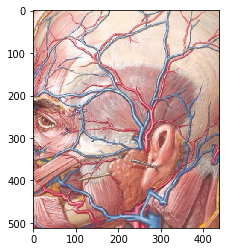

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

face = load_img('images/styles/face_crop.jpg')

udnie =load_img('images/styles/udnie.jpg')
udnie = tf.image.resize(udnie, [256, 256])
print(face.shape)
imshow(face.numpy().astype(np.uint8))

In [23]:
model = transformer_model()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#               loss=losses.full_loss(face))
model.load_weights('face_cropped.h5')

created


In [ ]:
model = 1
model = transformer_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=losses.full_loss(face))

In [10]:
model.load_weights('udniein_resizestyle_sw5_cw1_tv1e-5_coco.h5')
results = model.predict(face)

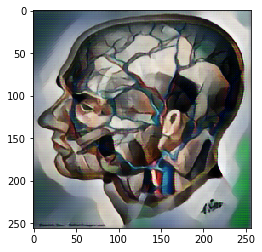

In [11]:
plt.imshow(results[0].astype(np.uint8))

254.3933 0.331398


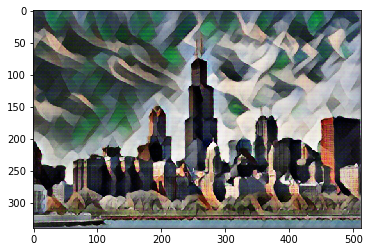

In [9]:
chicago = load_img('images/chicago.jpg')

# chicago = tf.image.resize(chicago, [256, 256])
results = model.predict(chicago)
plt.imshow(results[0].astype(np.uint8))
print(np.max(results[0]), np.min(results[0]))

In [7]:
model.fit(train_ds, epochs=50, steps_per_epoch=None, use_multiprocessing=False)

Epoch 1/50
639/639 [==============================] - 651s 1s/step - loss: 378027.6587
Epoch 2/50
639/639 [==============================] - 629s 984ms/step - loss: 219746.8601
Epoch 3/50
639/639 [==============================] - 630s 985ms/step - loss: 215751.5345
Epoch 4/50
639/639 [==============================] - 629s 984ms/step - loss: 213564.0755
Epoch 5/50
 28/639 [>.............................] - ETA: 11:45 - loss: 213957.3374

KeyboardInterrupt: 

In [8]:
model.save('face_cropped.h5')